<a href="https://colab.research.google.com/github/SemyonSinchenko/StartCode/blob/Sinchenko/Sinchenko2018Problem1/MST_with_SGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [0]:
plt.style.use('ggplot')

In [3]:
tf.__version__

'1.13.0-rc1'

Постановка задачи:
* Дана матрица смежности A полного взвешенного графа G ($A_{ij} \geq 0 \in R$)
* Найти методом градиентного спуска такую матрицу X, что матрица $A \odot X$ есть матрица смежности минимального остовного дерева G

Так как задача должна решаться методом градиентного спуска, то будем рассматривать матрицу $X \in [0, 1]$ как матрицу вероятностей нахождения ребра {ij} в остовном дереве.

Будем опираться на следующие факты:
* Любое остовное дерево графа из N вершин содержит строго N-1 ребер
* Любое остовное дерево является ациклическим графом, а следовательно все собственные значения матрицы смежности ациклического графа строго равны нулю (так как это треугольная матрица с нулями на диагонали)

Отсюда мы получаем следующие ограничения:
* $\sum_{i=1}^{N}\sum_{j=1}^{N}{X_{ij} \to (N - 1)}$ : граф является графом на N - 1 вершинах
* $\sum_{i}{\lambda_i} \to 0$, где $\lambda_i$ это собственные числа матрицы $A \odot X$ : граф является ацикличным
* $\sum_{i=1}^{N}\sum_{j=1}^{N}{(A_{ij}*X_{ij})} \to min$ : граф является минимальным остовным деревом

Будем минимизировать следующий функционал:
$L = \sum_{i=1}^{N}\sum_{j=1}^{N}{(A_{ij}*X_{ij})} + |\sum_{i=1}^{N}\sum_{j=1}^{N}{X_{ij} - (N - 1)}| + \sum_{i}{|\lambda_i|}$

In [0]:
def loss_function(X, A):
  '''
  The loss function.
  
  Keyword arguments:
  X - matrix of X_ij, probabilities that edge ij is in the Tree
  A - adjacency matrix of the Graph
  
  Return:
  Loss
  '''
  
  weights_part = tf.reduce_sum(tf.multiply(X, A))
  tree_limit = tf.abs(tf.abs(tf.reduce_sum(X)) - (int(A.shape[0]) - 1))
  e, _ = tf.linalg.eigh(tf.multiply(X, A))
  eigen_part = tf.reduce_sum(tf.square(e))
  
  return 0.5*weights_part + tree_limit + eigen_part

In [0]:
def get_adj_matrix(X, A):
  '''
  Get adjacency of tree from weights X and adjacency X.
  
  Keyword arguments:
  X - matrix of X_ij, probabilities that edge ij is in the Tree
  A - adjacency matrix of the Graph
  
  Return:
  new_adj - new adjacency matrix with threshold 0.5
  '''
  
  labels = tf.to_float(tf.greater_equal(X, 0.5))
  
  return tf.multiply(labels, A)

In [0]:
def alg(A, steps=5000):
  '''
  Main algorithm.
  
  Keyword arguments:
  A - adjacency matrix of the Graph
  steps - the number of steps in gradient descent process
  
  Return:
  X - matrix of learned weights
  T - adjacency matrix of MST  
  '''
  
  def prob_constr(T):
    return tf.clip_by_value(T, 0, 1)
  
  with tf.variable_scope("MST", reuse=tf.AUTO_REUSE):
    X = tf.get_variable('Probs',
                        A.shape,
                        dtype=tf.float32,
                        initializer=tf.ones_initializer(),
                        constraint=prob_constr)
    A = tf.constant(A,
                    dtype=tf.float32,
                    name='Adjacency')
    
    loss = loss_function(X, A)
    opt = tf.train.MomentumOptimizer(1e-3, 0.9, use_nesterov=True)
    train = opt.minimize(loss)
  
  initializer = tf.global_variables_initializer()
  
  with tf.Session() as sess:
    sess.run(initializer)
    for step in range(steps):
      sess.run(train)
    
    x_matrix = sess.run(X)
    tree_adj_matrix = sess.run(get_adj_matrix(X, A))
    
  return (x_matrix, tree_adj_matrix)

In [0]:
random_weights = np.abs(np.random.normal(0, 1, (10, 10)))

In [0]:
G = nx.from_numpy_array(random_weights)

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


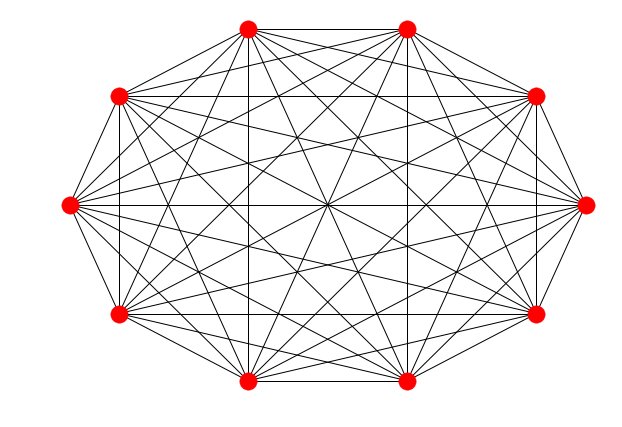

In [9]:
nx.draw_circular(G)

In [10]:
x_matrix, tree_adj = alg(random_weights)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [0]:
MST = nx.from_numpy_array(tree_adj)

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


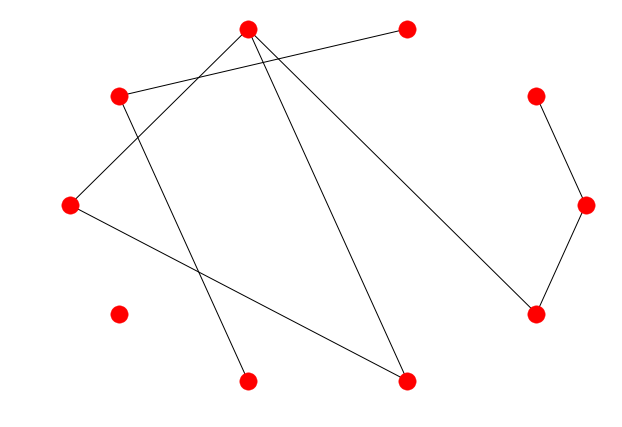

In [12]:
nx.draw_circular(MST)

In [13]:
nx.is_tree(MST)

False

In [14]:
MST.number_of_edges()

9

Мы видим, что алгоритм "почти" сходится к тому, что необходимо.

В целом, учитывая сильную неустойчивость алгоритма, я считаю, что задание выполнено - я ввел функцию потерь и нашел способ поиска Minimal Spanning Tree при помощи градиентного спуска, даже несмотря на то, что остовное дерево строго получено не было.

Алгоритм крайне чувствителен к гиперапараметрам, начальной инициализации, а также весов частей входящих в функцию потерь.
Со временем я планирую доработать алгоритм.